<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [42]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split , cross_val_score ,cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
sns.set_style('darkgrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [43]:
house = pd.read_csv('./housing.csv')

In [44]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [45]:
#C (all) is non residential
house.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [46]:
#drop all non-residential entries
drop_list = list(house[house['MSZoning']=="C (all)"].index)
house.drop(index = drop_list,inplace = True)

In [47]:
#create new feature age_sold
house['age_sold'] = house['YrSold']-house['YearRemodAdd']

In [48]:
#drop columns that is not a characteristic of house
not_house_char = ['Id','MoSold','YearBuilt','YearRemodAdd','SaleType','GarageYrBlt']
house.drop(columns =(not_house_char) , inplace = True)


In [49]:
fixed_var = ['MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley','LotShape',
             'LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1',
             'Condition2','BldgType','HouseStyle','RoofStyle','MasVnrArea','Foundation',
             'BsmtExposure','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','BsmtFullBath',
             'BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd',
             'Fireplaces','GarageType','GarageCars','GarageArea','PavedDrive','WoodDeckSF',
             'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
             'MiscFeature','MiscVal','SaleCondition','SalePrice','YrSold']
not_fixed = [i for i in house.columns if i not in fixed_var]
house_fixed = house[fixed_var]
house_renov = house[not_fixed]


In [50]:
house_fixed.isnull().sum().sort_values(ascending= False)

MiscFeature      1398
Alley            1361
LotFrontage       259
GarageType         79
BsmtExposure       38
MasVnrArea          8
YrSold              0
Foundation          0
RoofStyle           0
HouseStyle          0
BldgType            0
Condition2          0
Condition1          0
LandSlope           0
Neighborhood        0
1stFlrSF            0
LotConfig           0
Utilities           0
LandContour         0
LotShape            0
Street              0
LotArea             0
MSZoning            0
TotalBsmtSF         0
GrLivArea           0
2ndFlrSF            0
SalePrice           0
SaleCondition       0
MiscVal             0
PoolArea            0
ScreenPorch         0
3SsnPorch           0
EnclosedPorch       0
OpenPorchSF         0
WoodDeckSF          0
PavedDrive          0
GarageArea          0
GarageCars          0
Fireplaces          0
TotRmsAbvGrd        0
KitchenAbvGr        0
BedroomAbvGr        0
HalfBath            0
FullBath            0
BsmtHalfBath        0
BsmtFullBa

In [51]:
#misc value will already describe how the feature will affect the price
house_fixed.drop(columns = 'MiscFeature',inplace = True)

In [52]:
house_fixed.loc[house_fixed['Alley'].isnull(),"Alley"] = "N"
house_fixed.loc[house_fixed['GarageType'].isnull(),"GarageType"] = "N"

In [53]:
house_fixed['MasVnrArea'] = house_fixed['LotFrontage'].replace(np.nan,0)

C:\Users\B6NT\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [54]:
house_fixed.loc[house_fixed['BsmtExposure'].isna(),"BsmtExposure"] = "N"

In [55]:
#find mean of lot frontage
frontage_mean = np.mean(house_fixed['LotFrontage'].dropna())

In [56]:
#impute na with mean value
house_fixed.loc[house_fixed['LotFrontage'].isna(),"LotFrontage"] = frontage_mean

In [57]:
len(house_fixed.columns)

46

In [58]:
house_fixed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 46 columns):
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1450 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            1450 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
RoofStyle        1450 non-null object
MasVnrArea       1450 non-null float64
Foundation       1450 non-null object
BsmtExposure     1450 non-null object
TotalBsmtSF      1450 non-null int64
1stFlrSF         1450 non-null int64
2ndFlrSF         1450 non-null int64
GrLivArea        1450 

In [59]:
#found mssubclass wrong type
house_fixed['MSSubClass'] = house_fixed['MSSubClass'].astype(str)

C:\Users\B6NT\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [60]:
categorical = list(house_fixed.select_dtypes(include=['object']).columns)

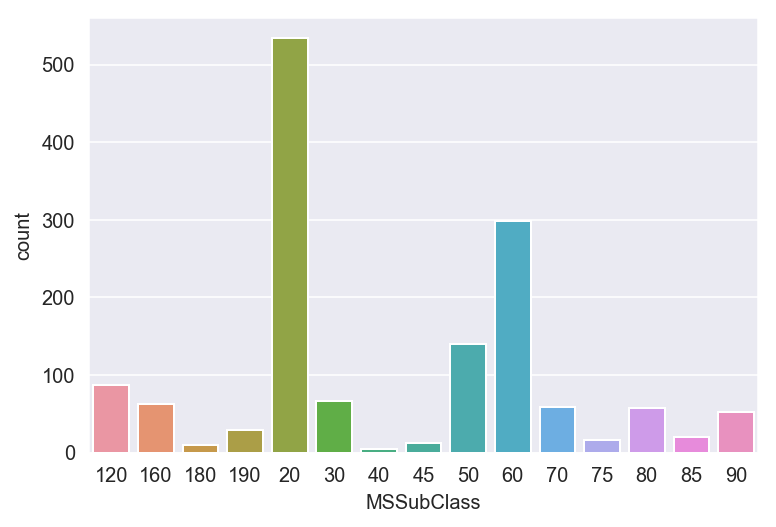

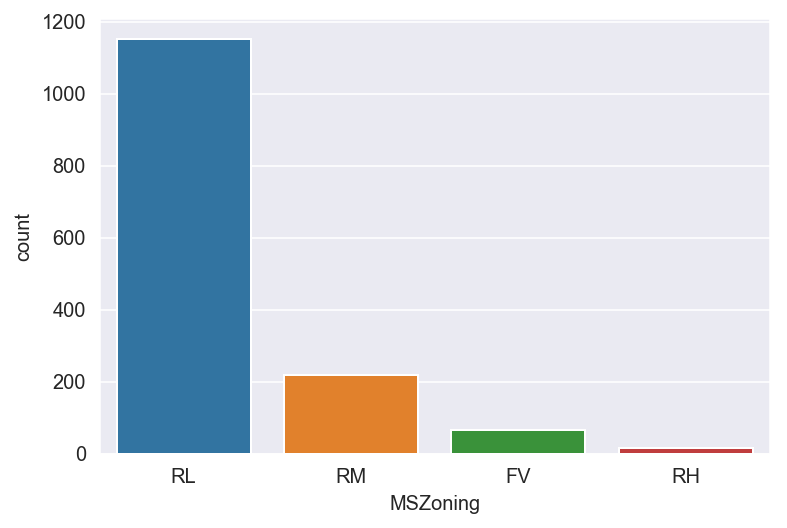

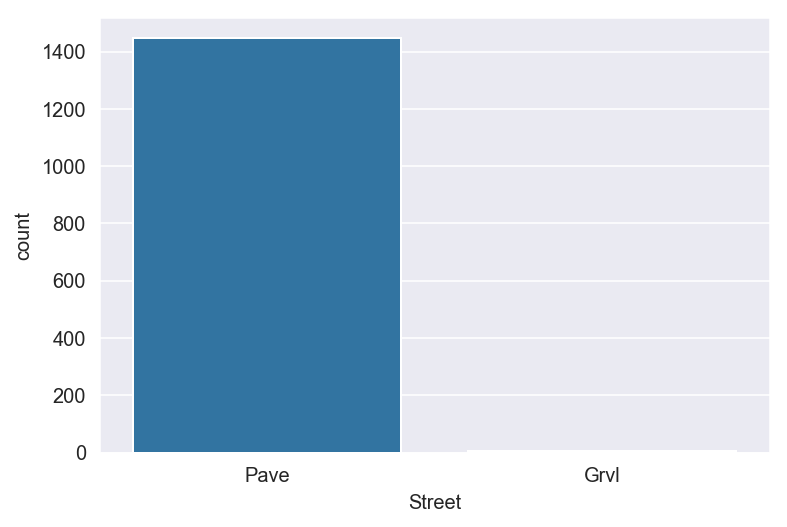

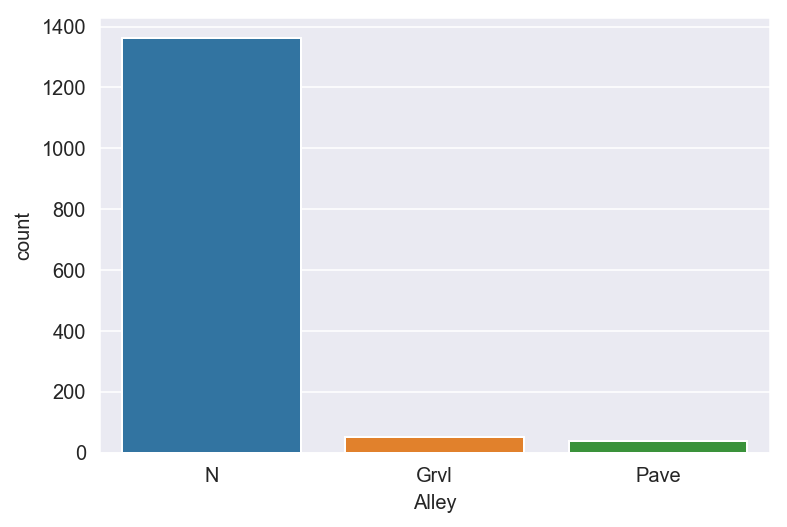

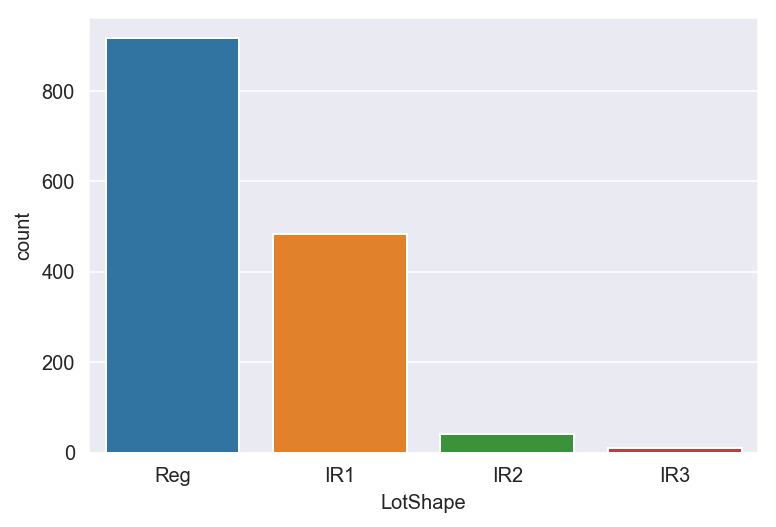

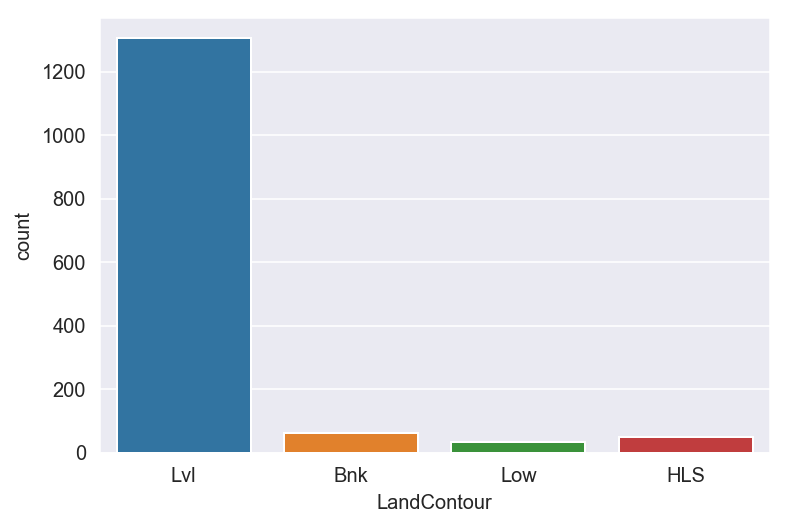

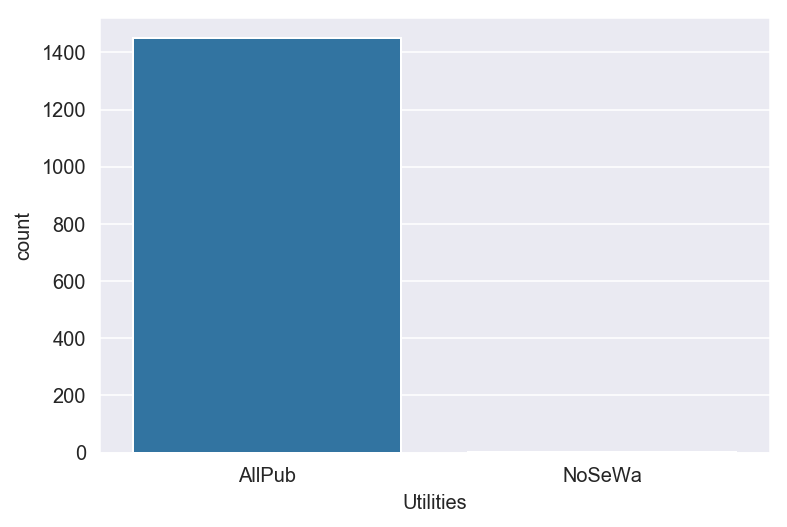

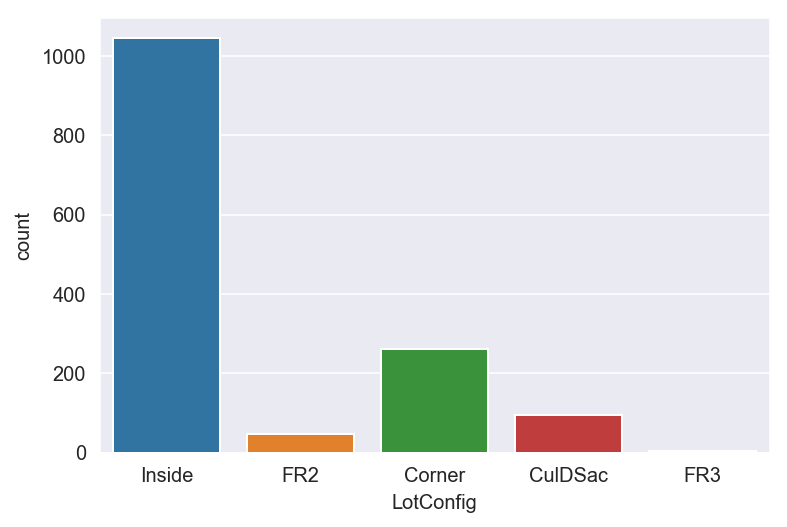

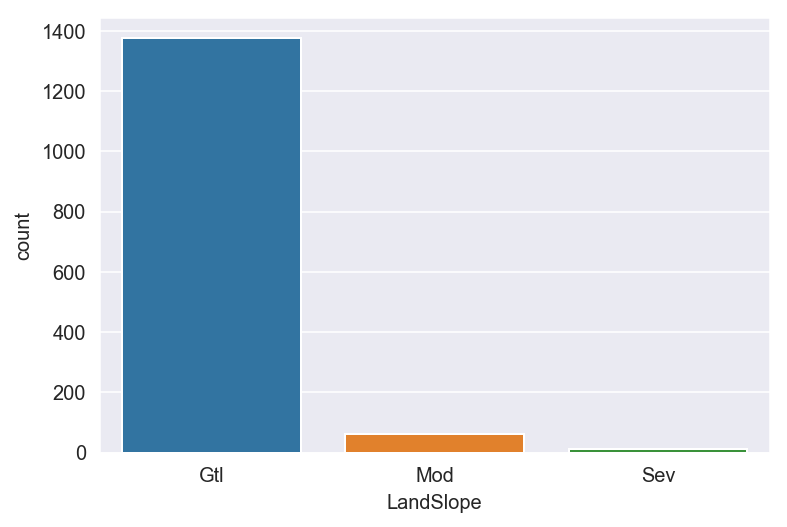

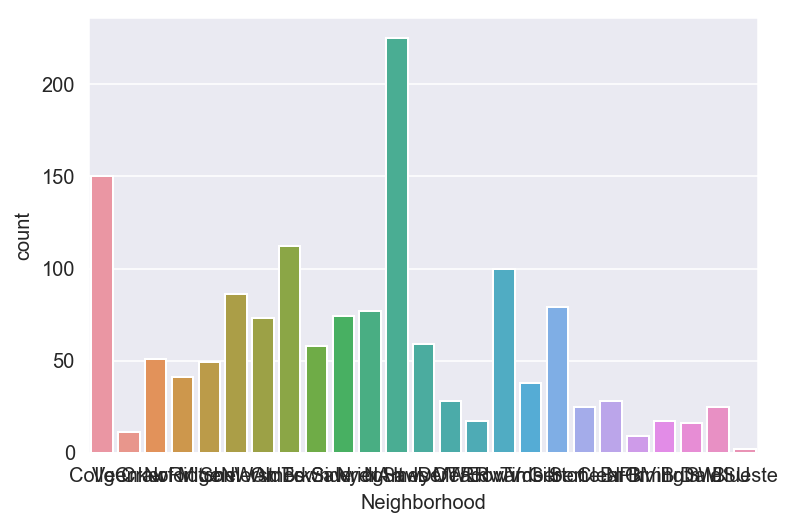

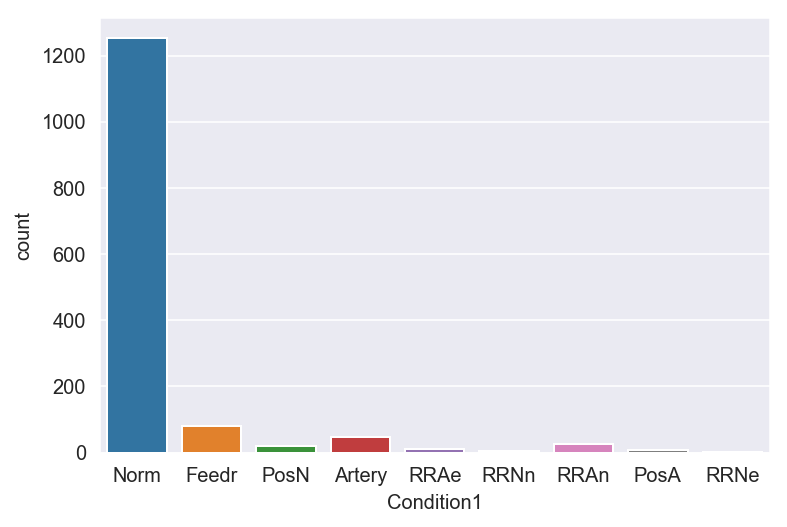

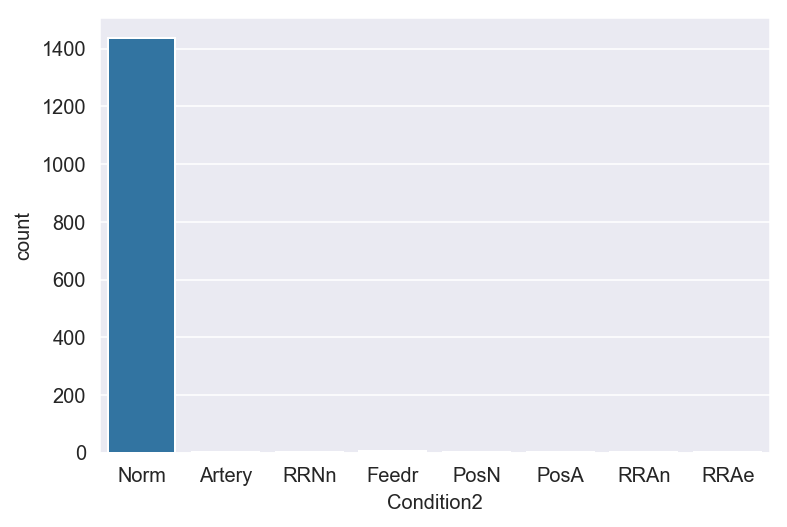

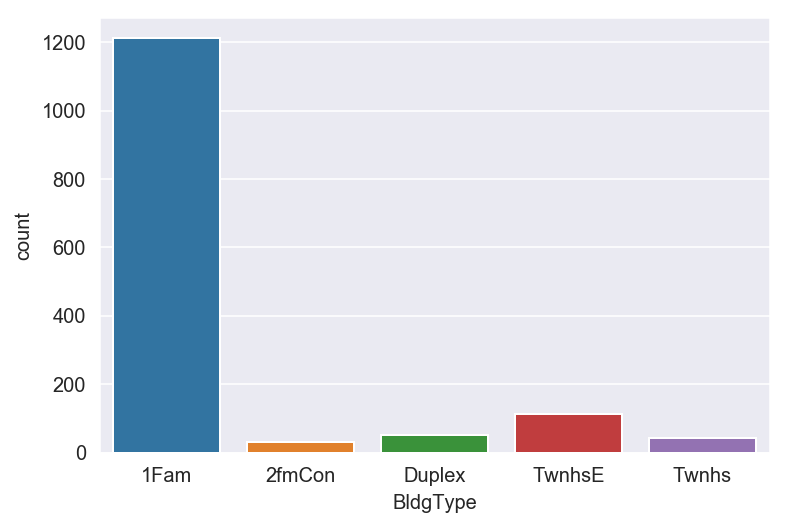

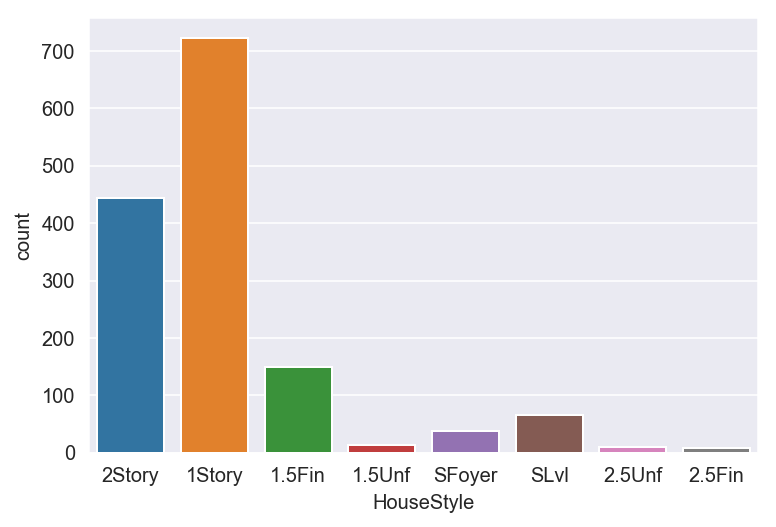

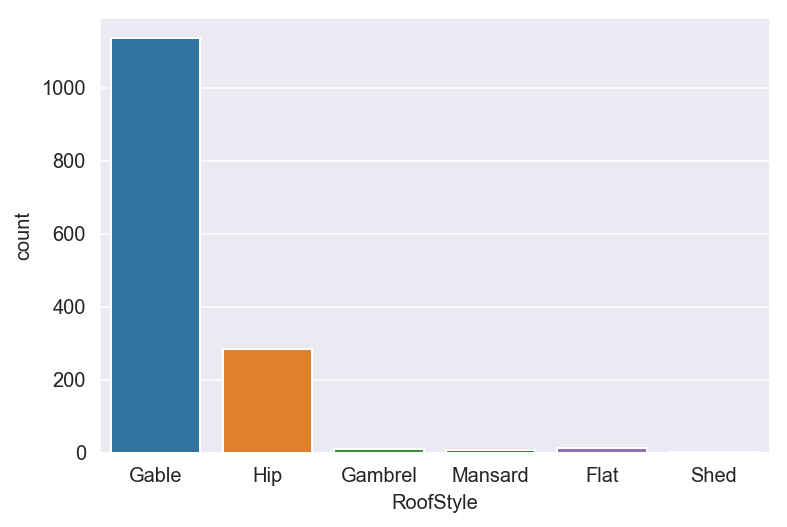

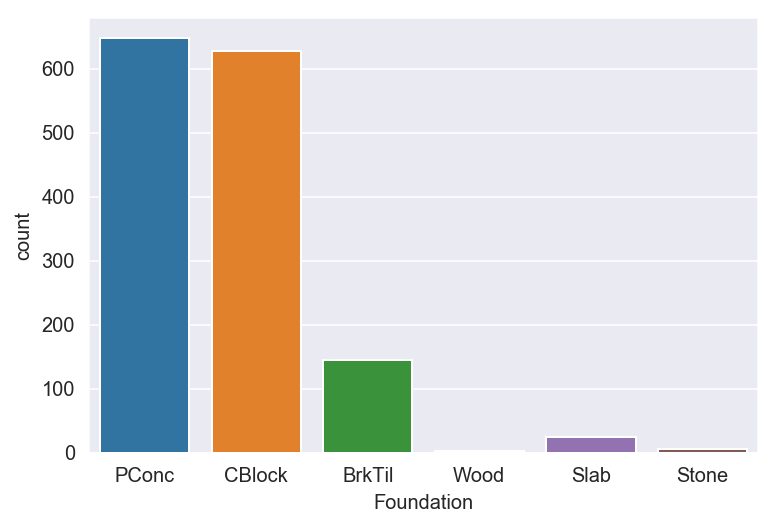

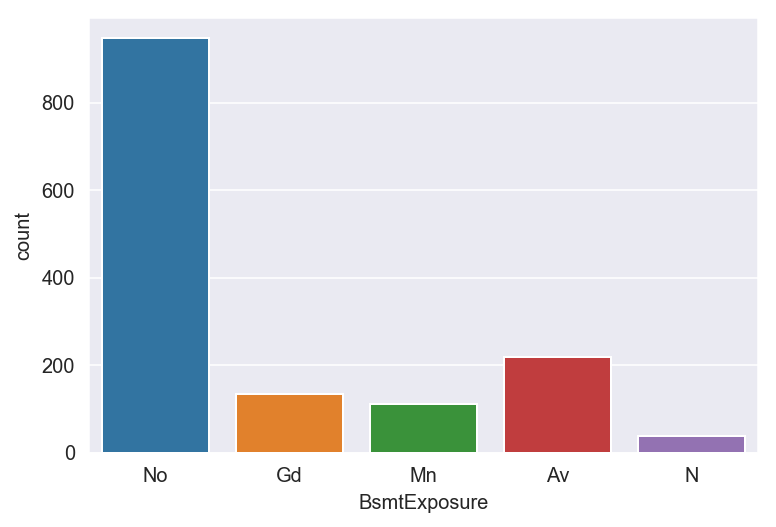

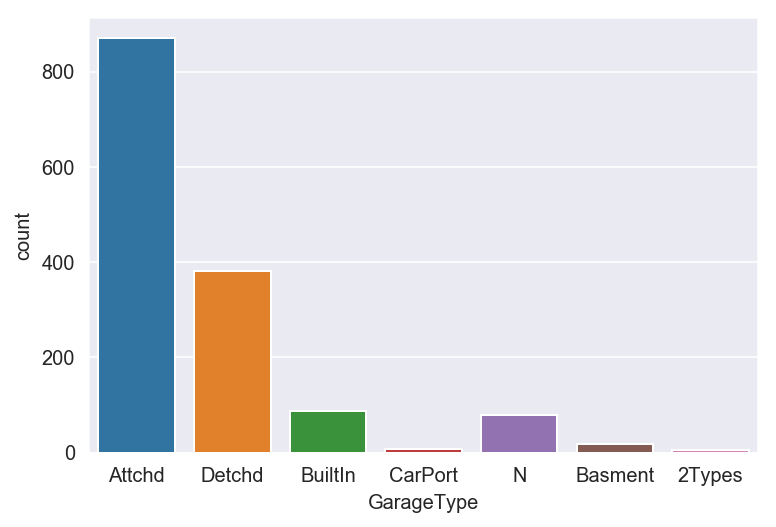

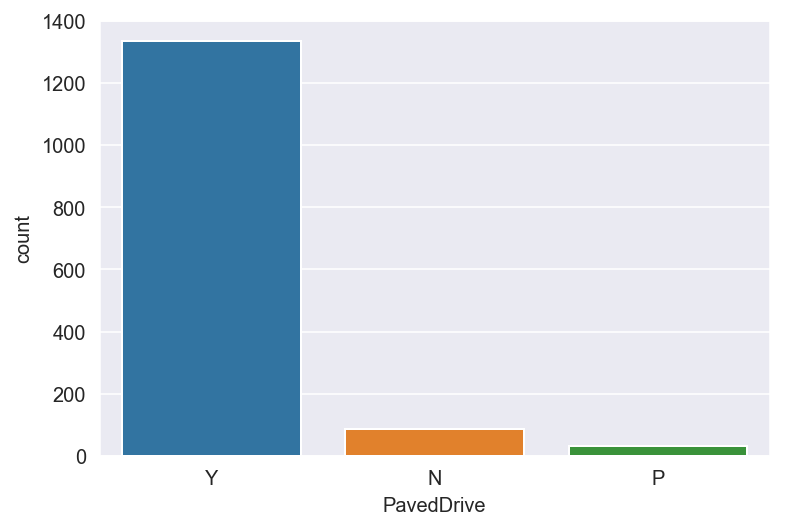

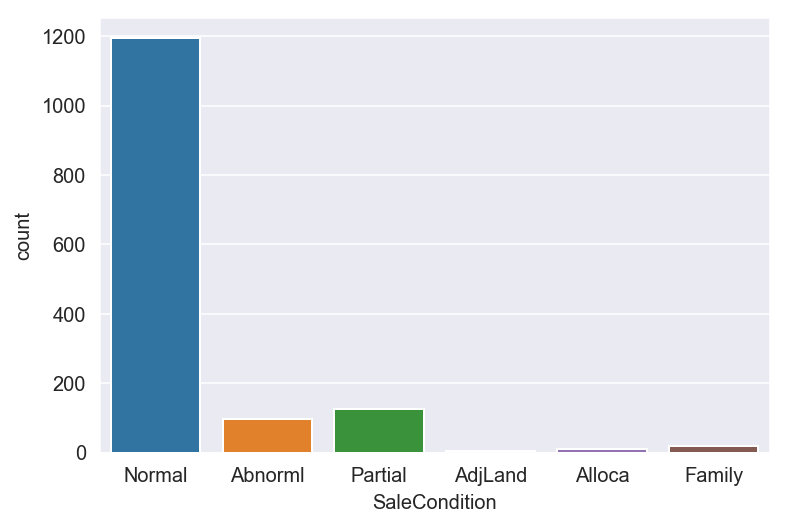

In [61]:
for col in categorical:
    ax = sns.countplot(x = col , data = house_fixed)
    plt.show()

In [62]:
#found 4 columns have severely low variance. Decided to drop as they are not meaningful.
low_variance_cat = ['Street','Utilities','Condition2','PavedDrive','LandSlope']
house_fixed = house_fixed.drop(columns = low_variance_cat)

In [63]:
continuous = list(house_fixed.select_dtypes(include=['int64','float64']).columns)

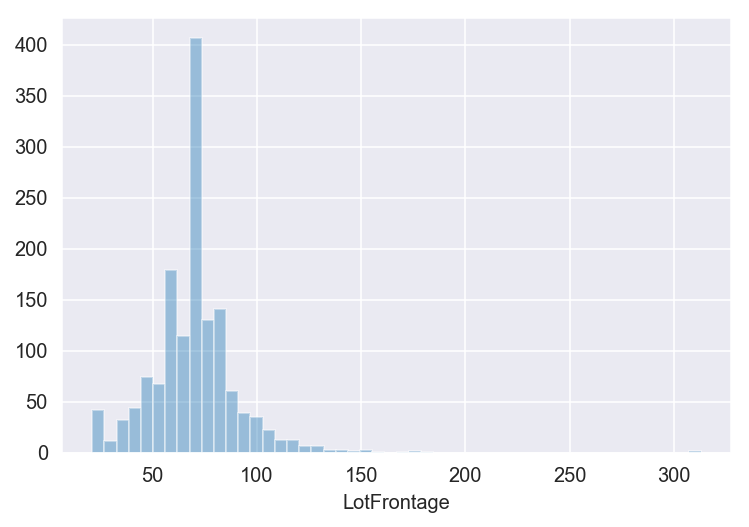

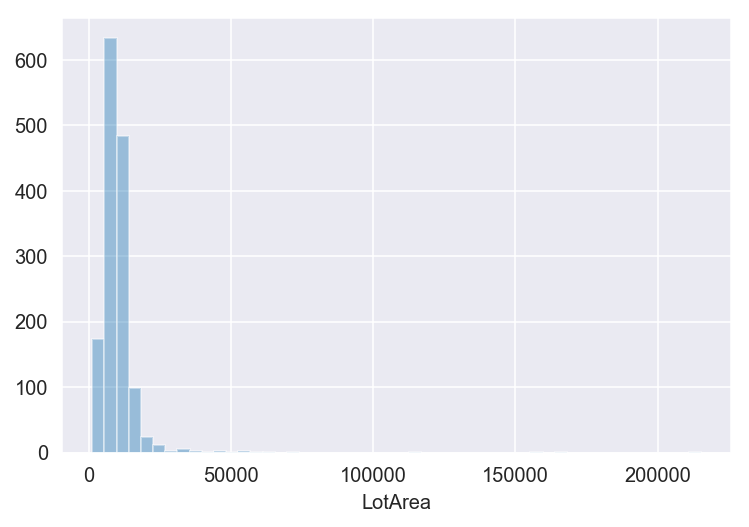

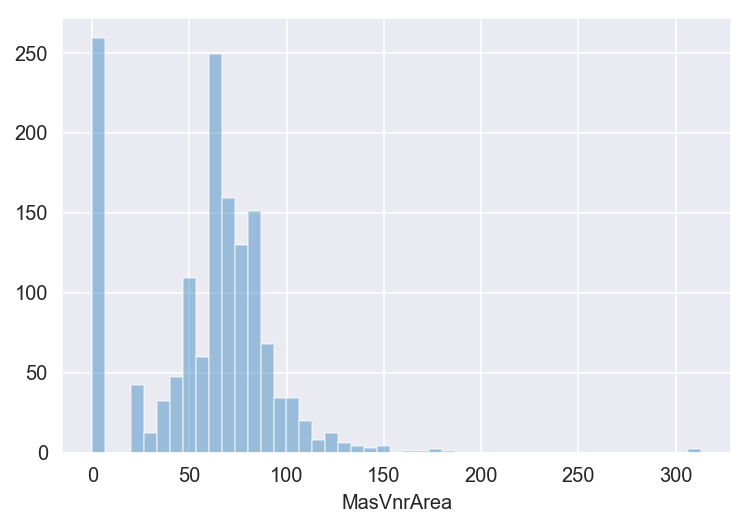

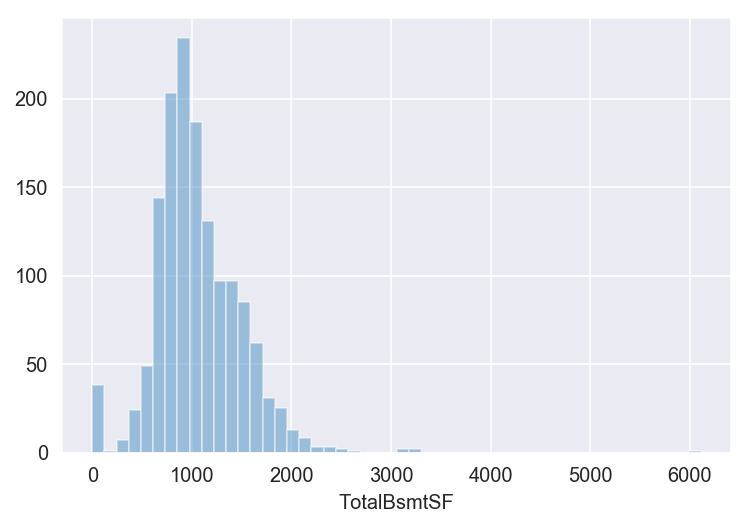

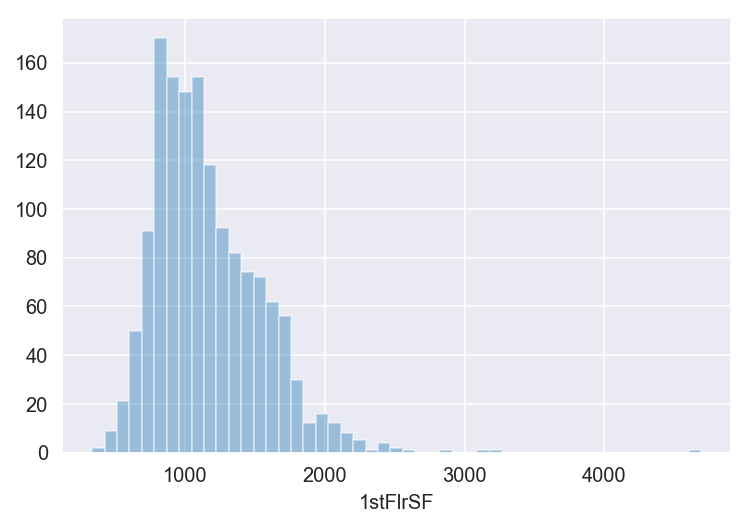

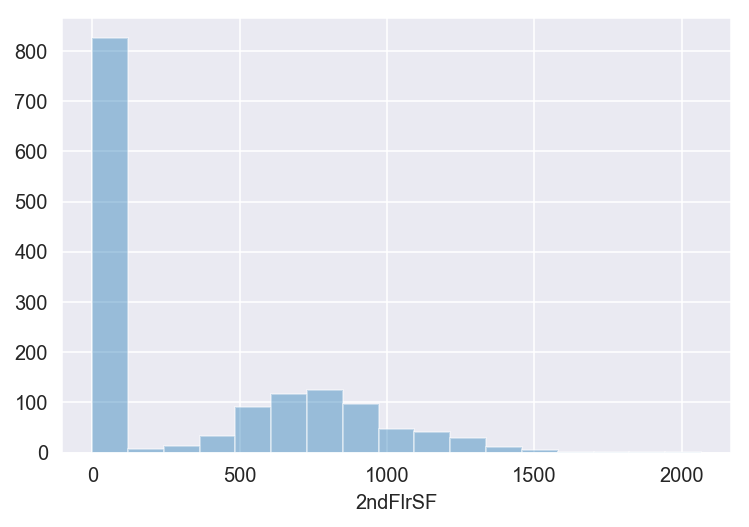

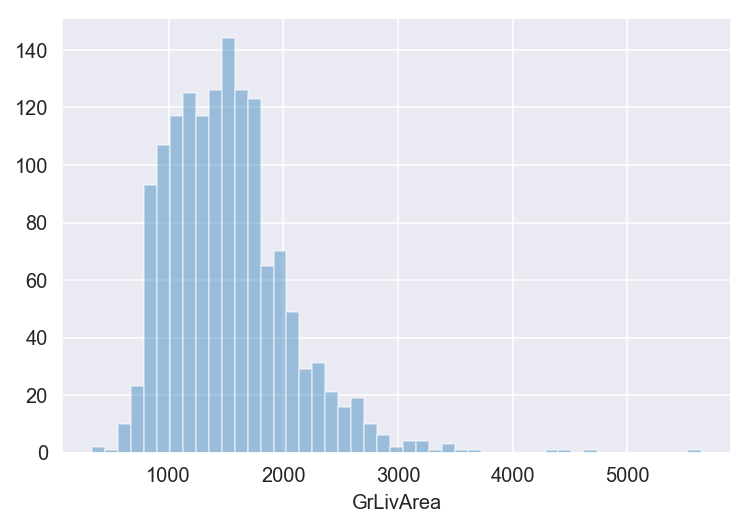

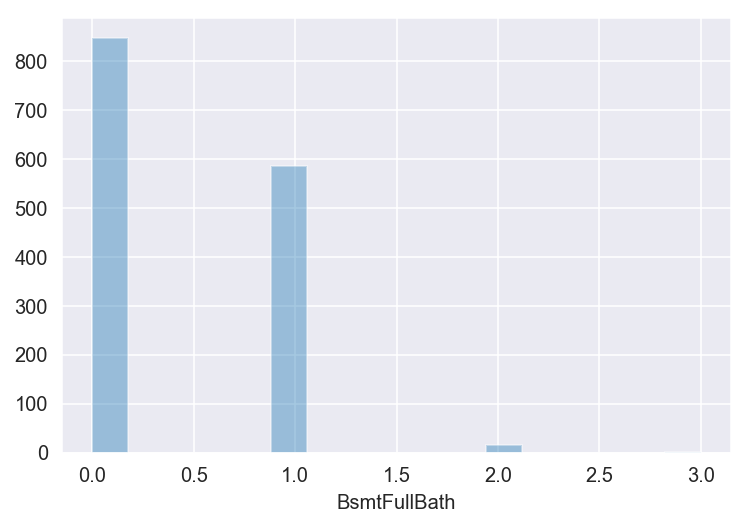

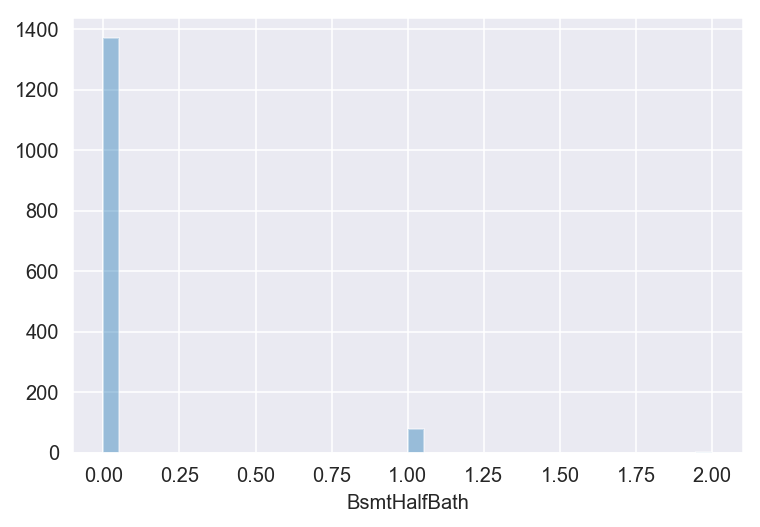

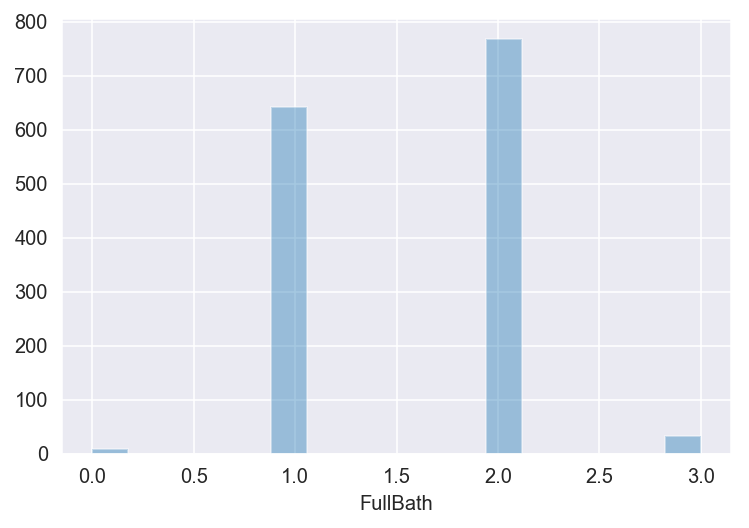

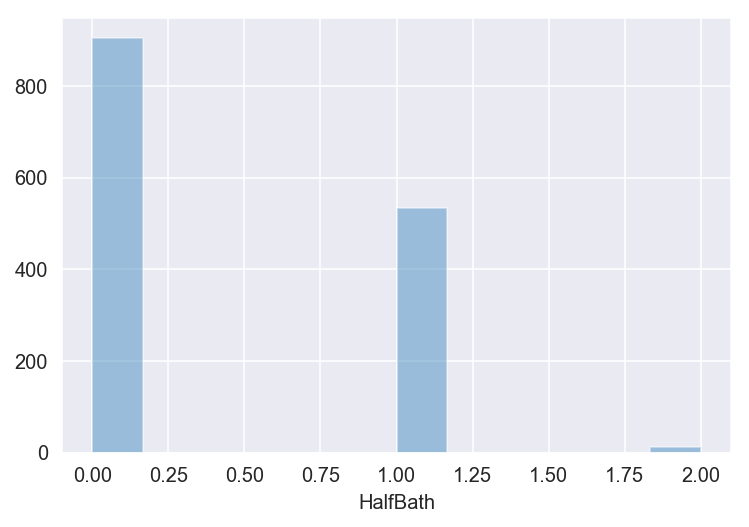

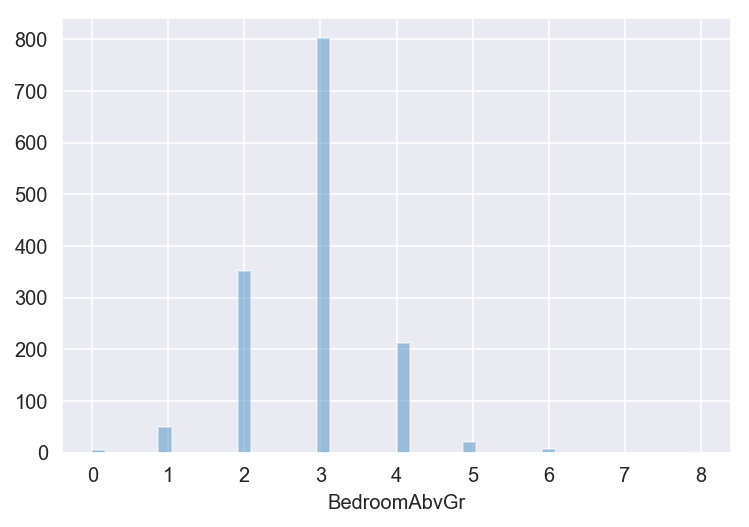

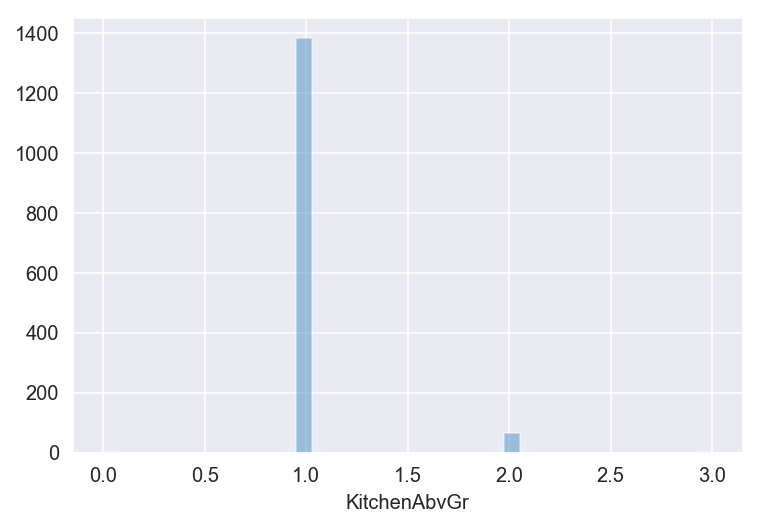

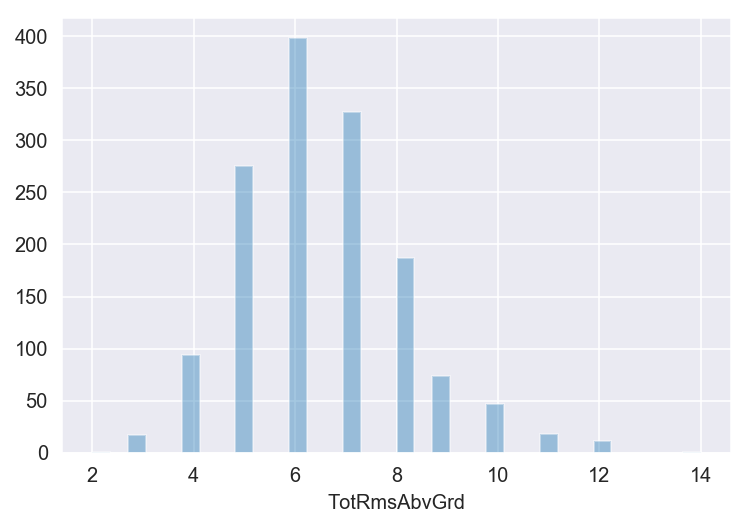

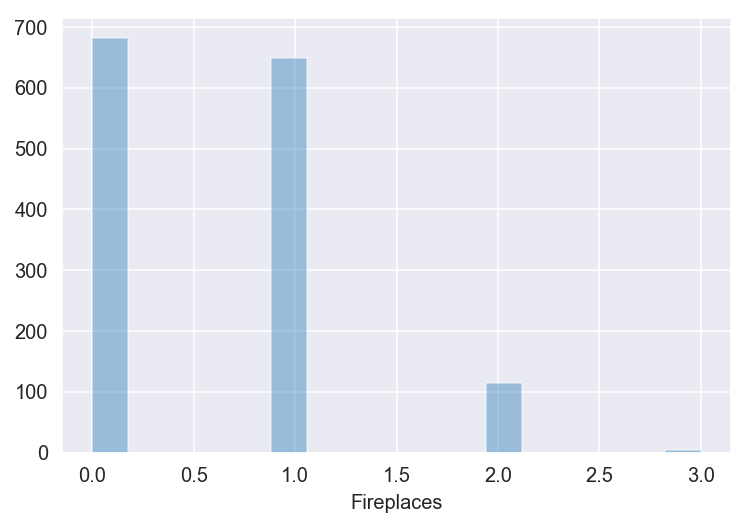

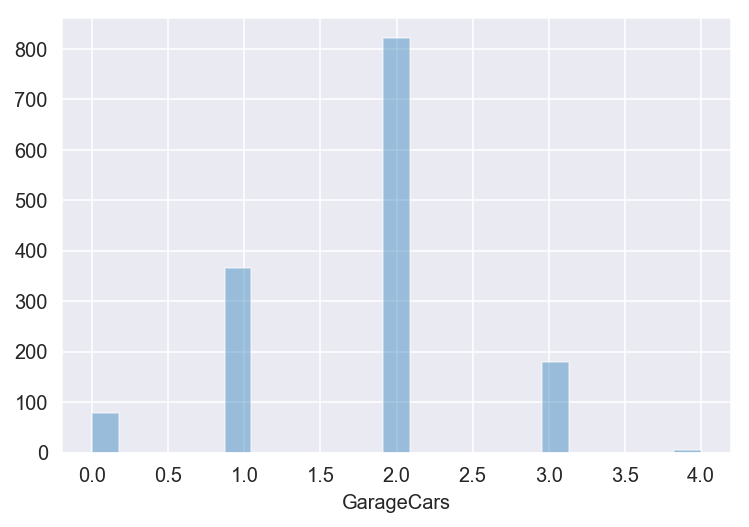

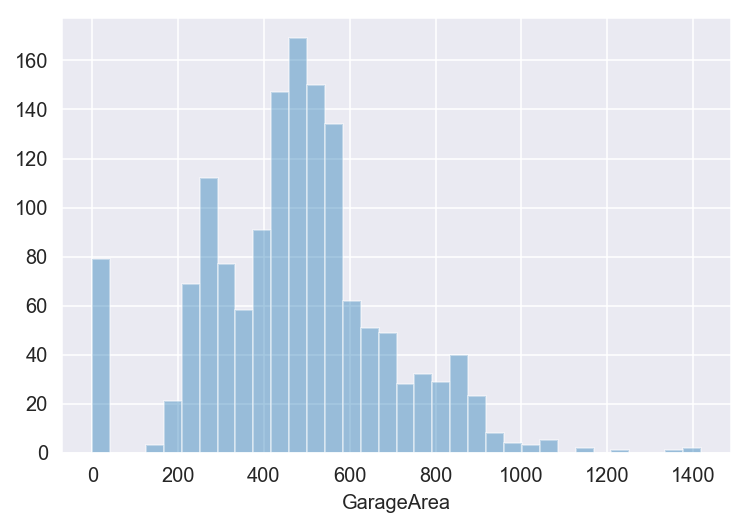

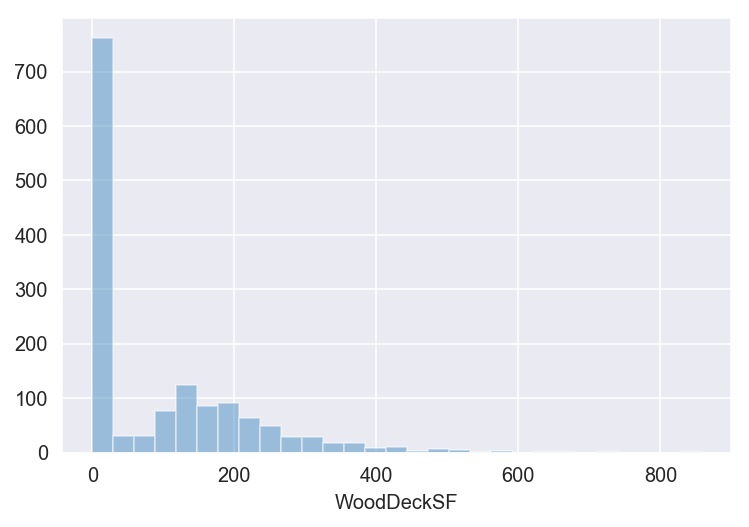

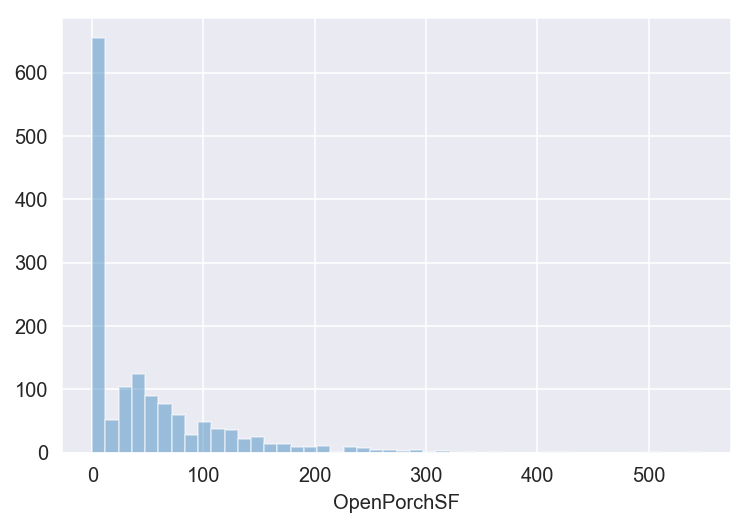

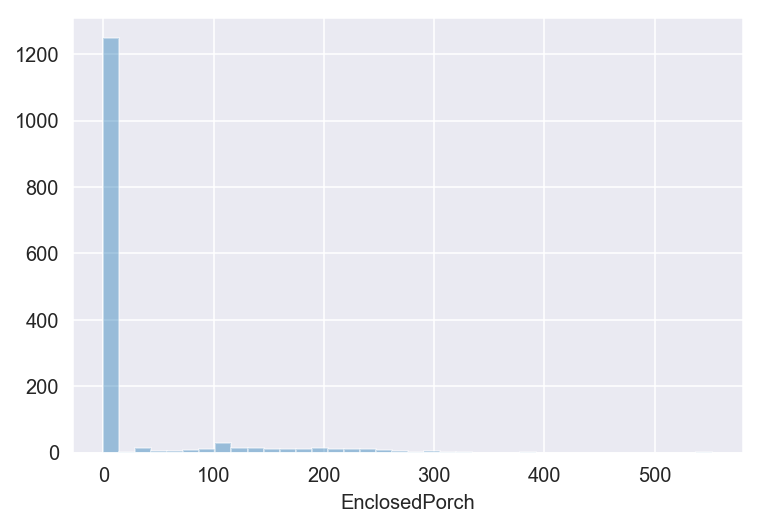

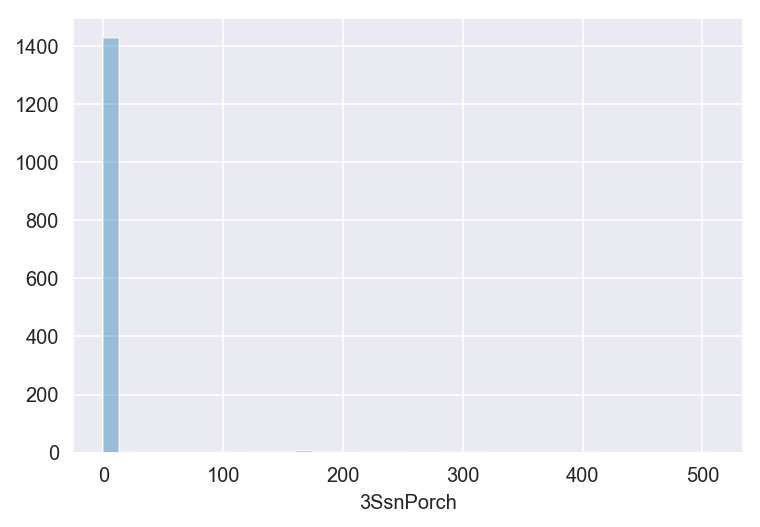

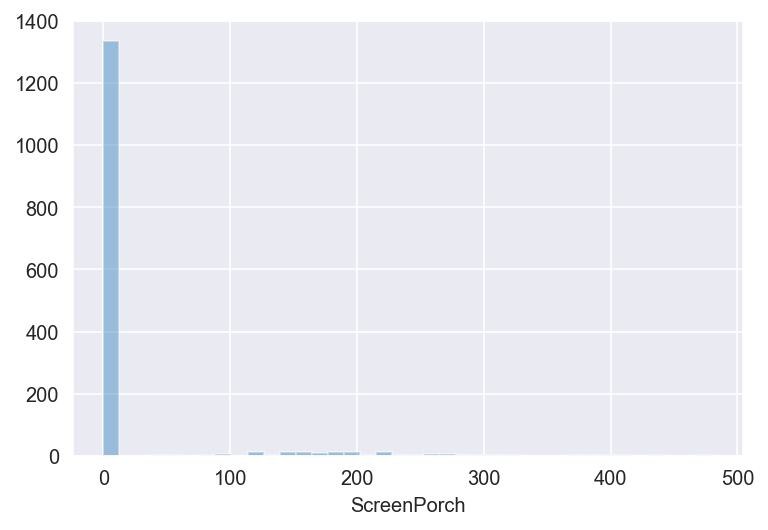

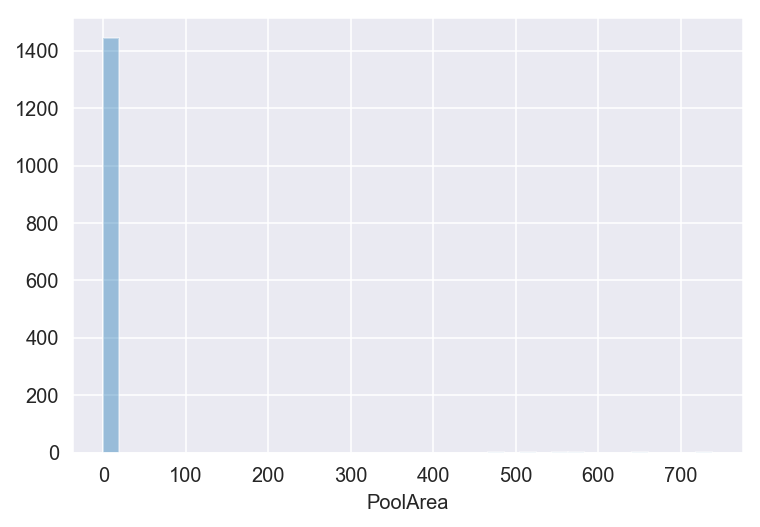

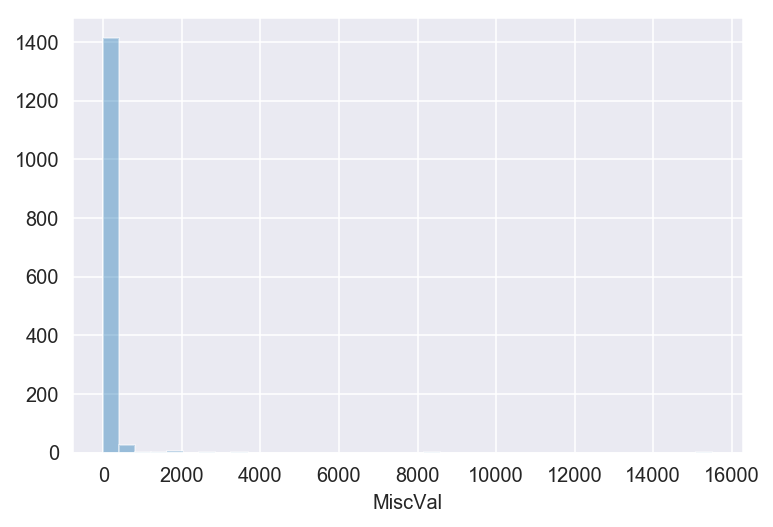

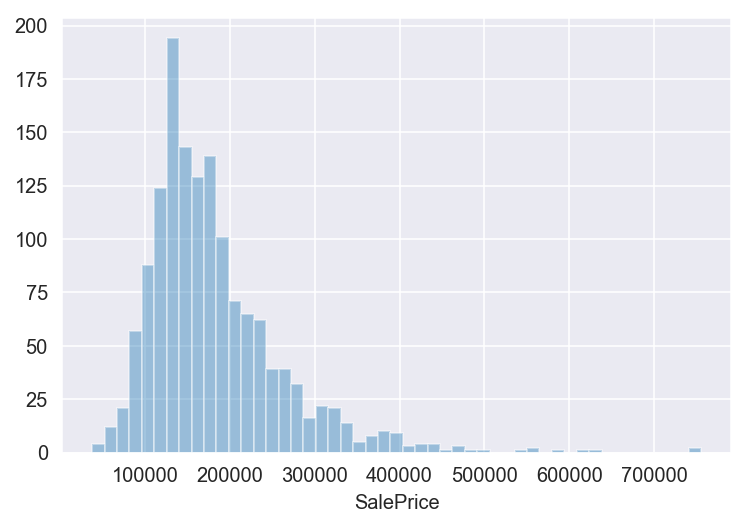

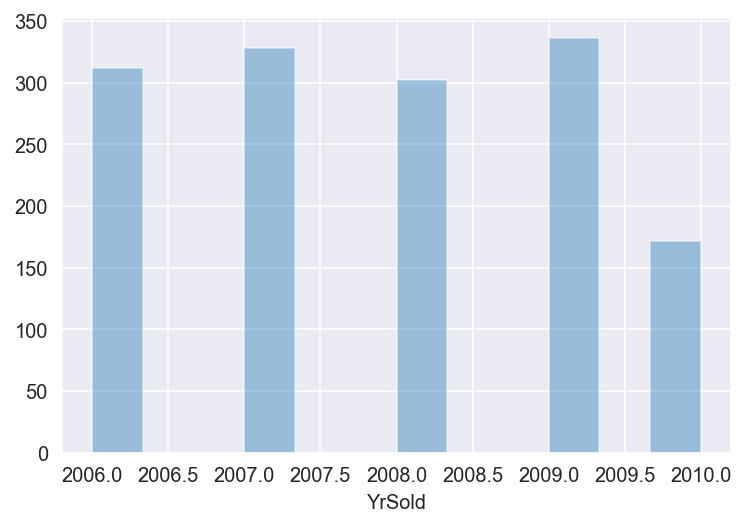

In [64]:
for col in continuous:
    ax = sns.distplot(house_fixed[col],kde=False )
    plt.show()

In [65]:
#decided to drop columns that has severely low variance. Except for Misc Value
#Believe that Misc Value is important for prediction of house value
low_variance_cont = ['KitchenAbvGr','BsmtHalfBath','EnclosedPorch'
                     ,'3SsnPorch','ScreenPorch','PoolArea']

house_fixed = house_fixed.drop(columns = low_variance_cont)

In [66]:
house_fixed.select_dtypes(include=['int64','float64']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 20 columns):
LotFrontage     1450 non-null float64
LotArea         1450 non-null int64
MasVnrArea      1450 non-null float64
TotalBsmtSF     1450 non-null int64
1stFlrSF        1450 non-null int64
2ndFlrSF        1450 non-null int64
GrLivArea       1450 non-null int64
BsmtFullBath    1450 non-null int64
FullBath        1450 non-null int64
HalfBath        1450 non-null int64
BedroomAbvGr    1450 non-null int64
TotRmsAbvGrd    1450 non-null int64
Fireplaces      1450 non-null int64
GarageCars      1450 non-null int64
GarageArea      1450 non-null int64
WoodDeckSF      1450 non-null int64
OpenPorchSF     1450 non-null int64
MiscVal         1450 non-null int64
SalePrice       1450 non-null int64
YrSold          1450 non-null int64
dtypes: float64(2), int64(18)
memory usage: 277.9 KB


In [67]:
#binarize bsmtfullbath 
house_fixed['BsmtFullBath'] = house_fixed['BsmtFullBath'].map(lambda x: 0 if x == 0 else 1)
house_fixed['FullBath'] = house_fixed['FullBath'].map(lambda x: 1 if x >=2 else 0)
house_fixed['HalfBath'] = house_fixed['HalfBath'].map(lambda x: 1 if x >=1 else 0)
house_fixed['Fireplaces'] = house_fixed['Fireplaces'].map(lambda x: 1 if x >=1 else 0)
#change all bath column and fireplaces column to object
to_object = ['BsmtFullBath','FullBath','HalfBath','Fireplaces']
house_fixed[to_object] = house_fixed[to_object].astype(str)

In [68]:
house_fixed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 35 columns):
MSSubClass       1450 non-null object
MSZoning         1450 non-null object
LotFrontage      1450 non-null float64
LotArea          1450 non-null int64
Alley            1450 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
LotConfig        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
RoofStyle        1450 non-null object
MasVnrArea       1450 non-null float64
Foundation       1450 non-null object
BsmtExposure     1450 non-null object
TotalBsmtSF      1450 non-null int64
1stFlrSF         1450 non-null int64
2ndFlrSF         1450 non-null int64
GrLivArea        1450 non-null int64
BsmtFullBath     1450 non-null object
FullBath         1450 non-null object
HalfBath         1450 non-null object
BedroomAbvGr     1450 

In [69]:
#get a list of all object column and apply get_dummies
categorical = list(house_fixed.select_dtypes(include=['object']).columns)
df_dummies = pd.get_dummies(house_fixed[categorical], drop_first=True)
len(df_dummies.columns)

101

In [70]:
house_fixed= house_fixed.drop(columns = categorical)

In [71]:
house_fixed = pd.concat([house_fixed, df_dummies], axis=1)

In [72]:
#split data into 2010 and before 2010
house_fixed_2010 = house_fixed[house_fixed['YrSold'] == 2010]
y_test = house_fixed_2010[['SalePrice']]
X_test = house_fixed_2010.drop(columns = 'SalePrice')

house_fixed_training = house_fixed[house_fixed['YrSold'] < 2010]
y = house_fixed_training[['SalePrice']]
X = house_fixed_training.drop(columns = 'SalePrice')

In [73]:
# Initialize the StandardScaler object.
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
# Use the "fit_transform" function to standardize the X design matrix.
Xs = ss.fit_transform(X)
Xs_test = ss.transform(X_test)

model = LinearRegression()
# Perform cross-validation
scores = cross_val_score(model,Xs, y, cv=10)
print("Cross-validated scores:", scores)
print("Mean CV R2:", np.mean(scores))
print('Std CV R2:', np.std(scores))

model.fit(Xs,y)
model.score(Xs_test,y_test)

Cross-validated scores: [ 8.52246844e-01  8.29844081e-01  8.24746747e-01 -2.14447056e+17
  8.11785581e-01 -3.28860087e+23  8.31985770e-01  7.75149859e-01
 -4.04763357e+20  8.47356735e-01]
Mean CV R2: -3.2926506432104352e+22
Std CV R2: 9.864460050065031e+22


C:\Users\B6NT\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\B6NT\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\B6NT\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


0.8467943422264126

In [74]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
optimal_lasso = LassoCV(n_alphas=500, cv=10)
optimal_lasso.fit(Xs, y)
print(optimal_lasso.alpha_)

C:\Users\B6NT\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


605.6342769882765


In [75]:
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, Xs, y, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))

lasso.fit(Xs,y)
lasso.score(Xs_test,y_test)
# lasso_coefs = pd.DataFrame({'variable':X.columns,
#                             'coef':lasso.coef_,
#                             'abs_coef':np.abs(lasso.coef_)})

# lasso_coefs.sort_values('coef', inplace=True, ascending=False)

# lasso_coefs[lasso_coefs['coef']!=0]

[0.88923983 0.83790754 0.83905366 0.74292439 0.80374015 0.82086957
 0.83565963 0.77898066 0.56606699 0.86469187]
0.7979134280781565


0.8540923372582736

In [76]:
ridge_alphas = np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs, y)

print(optimal_ridge.alpha_)

255.95479226995386


In [81]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xs, y, cv=10)

print(ridge_scores)
print('Ridge Training Mean:',np.mean(ridge_scores))

ridge.fit(Xs, y)
print('Ridge Predict Score:', ridge.score(Xs_test,y_test))

# ridge_coef = ridge.coef_[0][:]
# ridge_coefs = pd.DataFrame({'variable':X.columns,
#                             'coef':ridge_coef,
#                             'abs_coef':np.abs(ridge_coef)})

# ridge_coefs.sort_values('abs_coef', inplace=True, ascending=False)

# ridge_coefs[ridge_coefs['coef']!=0]

[0.89443111 0.82231323 0.84303675 0.75618018 0.78739153 0.81287735
 0.84653582 0.79479684 0.57588345 0.8614904 ]
Ridge Training Mean: 0.7994936647894959
Ridge Predict Score: 0.8522502588270857


In [ ]:
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, 
                            n_alphas=30, 
                            cv=10, 
                            max_iter=10000)
optimal_enet.fit(Xs, y_train)

print(optimal_enet.alpha_)
print(optimal_enet.l1_ratio_)

In [ ]:
enet = ElasticNet(alpha=optimal_enet.alpha_, 
                  l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, Xs, y_train, cv=10)

print(enet_scores)
print(np.mean(enet_scores))

enet.fit(Xs, y_train)
enet_coef = enet.coef_
enet_coefs_df = pd.DataFrame({'variable':X.columns,
                            'coef':enet_coef,
                            'abs_coef':np.abs(enet_coef)})

enet_coefs_df.sort_values('abs_coef', inplace=True, ascending=False)
enet_coefs_df

In [ ]:
print(np.mean(enet_scores))
print(np.mean(ridge_scores))
print(np.mean(lasso_scores))

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, f_regression
cols = list(X_train.columns)
# Build the selector — we'll build one with each score type.
skb_f = SelectKBest(f_regression, k=5)

# Train the selector on the data.
skb_f.fit(Xs, y_train)

# Examine the results.
kbest = pd.DataFrame([cols, list(skb_f.scores_)], 
                     index=['feature','f_regression']).T.sort_values('f_regression', ascending=False)


In [ ]:
comparison = pd.concat([enet_coefs_df,kbest],axis=1)
comparison.sort_values(by='coef',ascending = False)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [ ]:
# A:

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A: